# **House prices**
***
### **Data Cleaning and Feature Engineering**

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,make_column_transformer,make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score,KFold


import warnings
warnings.simplefilter('ignore',DeprecationWarning)
warnings.simplefilter('ignore',FutureWarning)
pd.set_option("precision", 6)
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
# Import dataset
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print('Train Shape:',train.shape)
train.head(2)

Train Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [3]:
# We check how many columns have null values
train.isnull().any().sum()

19

In [4]:
# Which columns have null values
null_cols = train.columns[train.isnull().sum() > 0]
null_cols

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

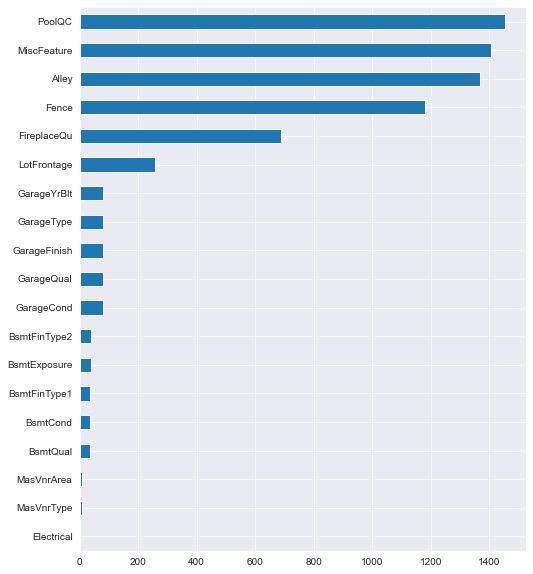

In [5]:
# What columns have more missing values
plt.figure(figsize=(8,10))
train[null_cols].isnull().sum().sort_values().plot(kind='barh')
plt.show()

### Columns can be dropped or combined. By now we will not do anything
- Some of them use nan to describe the absence of the quality. For example, in PoolQC nans are used when the house has no pool <br>

We can drop this columns <br> 
Be reading the columns descriptions, is easy to notice that some of them give no new information <br>
to_drop = ['Fence','MiscFeature','Alley','PoolQC','PoolArea','MiscVal','FireplaceQu']<br> 
train = train.drop(to_drop,axis=1) <br>
test = test.drop(to_drop,axis=1) <br>

***
## Explore sales 

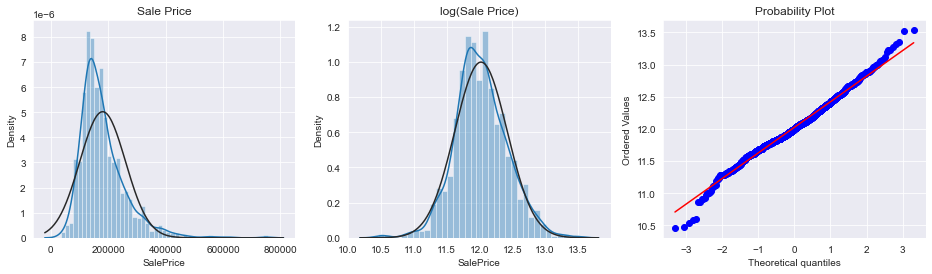

In [6]:
# there are signs of lognormallity or a similar distribution
y = train.SalePrice
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))

ax1.set_title('Sale Price')
sns.distplot(y,kde=True,ax=ax1,fit=st.norm)

ax2.set_title('log(Sale Price)')
sns.distplot(np.log(y),kde=True,ax=ax2,fit=st.norm)

st.probplot(np.log(y),plot=plt)  # afeter applying log to sales

plt.show()

### Create X and y

In [7]:
X = train[train.columns.difference(['SalePrice'])]
y = np.log(train.SalePrice) 

## Build a pipeline
- We wil build a pipeline that will preprocess the data and use GradientBoostingRegressor as model

In [8]:
# We create a preprocessor

# numerical
num_transf = Pipeline([('imputer',SimpleImputer(strategy='median')), # we fill with the median
                      ('scaler',StandardScaler())])

#categorical
cat_transf = Pipeline([('imputer',SimpleImputer(strategy='constant',fill_value='none')), # we do nothing with nans by now
                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

# All together
ct = make_column_transformer((num_transf,
                              make_column_selector(dtype_include=np.number)),    #continuous
                            (cat_transf,
                             make_column_selector(dtype_include=object)))    # categorical
# The model used
model = GradientBoostingRegressor(learning_rate=0.001)

# The pipe
pipe = Pipeline([('pre',ct),
                ('model',model)])

In [9]:
pipe.fit(X,y)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001EFAC79B248>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='none',
                                                                                 strategy='constant')),
                                                                  ('onehot',
    

In [10]:
# Lets use CV to see how well we perform
kf = KFold(shuffle=True)
scores = []
for i in range(6):
    scores.append(-cross_val_score(pipe,X,y,scoring='neg_mean_squared_error',cv=kf).mean())
    # Mean error repeating 10 cross_validation
print(f'The CV MSE is {np.mean(scores):.6f}')

The CV MSE is 0.139712


In [11]:
# we submit the prediction
pred = np.exp(pipe.predict(test))
sub = pd.DataFrame({'Id':test.Id, 'SalePrice':pred})
sub.to_csv('subs/sub1.csv',index=False)